In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import os
import detect
#import tflite as tf
import platform
import datetime
import cv2
import time
import numpy as np
import io
from io import BytesIO
from flask import Flask, request, Response, jsonify
import random
import re
import base64
import matplotlib.pyplot as plt

In [2]:
def display_image(image):
  res = base64.b64decode(image)
  res = Image.open(io.BytesIO(res))
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(res)

In [3]:
folder_path = r'C:\Users\maxsc\Desktop\TU\DIC3\Pictures_small'
images_s = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    # Construct the full file path
    file_path = os.path.join(folder_path, filename)

    # Check if the file is a JPEG image
    if os.path.isfile(file_path) and filename.lower().endswith(".jpg"):
        with open(file_path, "rb") as file:
            # Read the image data
            image_data = file.read()

            # Encode the image data as base64
            encoded_data = base64.b64encode(image_data).decode("utf-8")

            # Append the encoded string to the list
            images_s.append(encoded_data)

print(len(images_s))


296


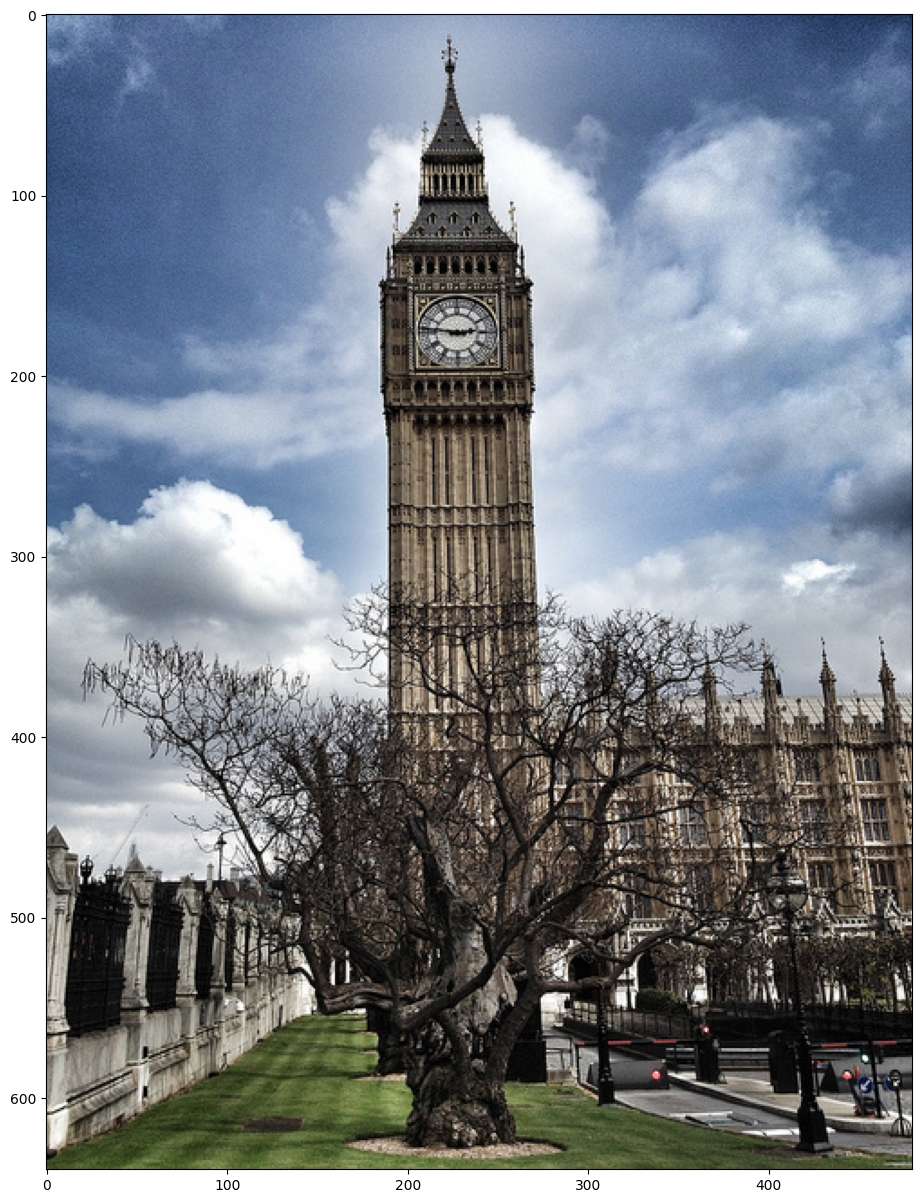

In [4]:
display_image(images_s[5])

In [5]:
#Preprocess ONE image
imgs = []

for i in images_s:
    image_bytes = base64.b64decode(i)
    image = Image.open(io.BytesIO(image_bytes))
    image = image.resize((300, 300))  # Resize to match the model's input size
    image_np = np.array(image).astype(np.float32)  # Convert PIL image to NumPy array
    imgs.append(image_np)


len(imgs)

296

In [6]:
#Load detector model

model_path = r"https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(model_path).signatures['default']



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
#CODE TO DO OBJECT DETECTION ON ONE IMAGE
img_nr = 5

converted_img  = tf.image.convert_image_dtype(imgs[img_nr], tf.float32)[tf.newaxis, ...]

start_time = time.time()
result = detector(converted_img)
end_time = time.time()
result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Found 100 objects.
Inference time:  13.430286407470703


In [8]:
det = {"entities" : [], "scores" : [], "boxes" : []}
def add_detections(result,max_length,det):
    det["entities"].append(result["detection_class_entities"][:max_length])
    det["scores"].append(result["detection_scores"][:max_length])
    det["boxes"].append(result["detection_boxes"][:max_length])
    return det

add_detections(result,10,det)


{'entities': [array([b'Street light', b'Street light', b'Street light', b'Street light',
         b'Tower', b'Skyscraper', b'Street light', b'Street light',
         b'Street light', b'Street light'], dtype=object)],
 'scores': [array([0.11828629, 0.10321251, 0.10157974, 0.09396127, 0.08872301,
         0.08324596, 0.08068882, 0.0798382 , 0.07714282, 0.07703003],
        dtype=float32)],
 'boxes': [array([[0.8161825 , 0.5942236 , 0.946982  , 0.6277622 ],
         [0.8712192 , 0.86810124, 0.96807534, 0.89301014],
         [0.81866425, 0.65403086, 0.9333903 , 0.67874783],
         [0.88937294, 0.82969797, 0.9523963 , 0.84949327],
         [0.02914152, 0.3443219 , 0.72115564, 0.58403844],
         [0.03964671, 0.32462704, 0.84898293, 0.6083885 ],
         [0.7074816 , 0.13338389, 0.7767706 , 0.15005396],
         [0.7896786 , 0.5449162 , 1.        , 0.6585631 ],
         [0.9615062 , 0.8697396 , 0.9898624 , 0.8989261 ],
         [0.8613949 , 0.60988384, 0.9558054 , 0.6354757 ]], dtype=flo